In [1]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [2]:
btvote = pd.read_pickle('../data/btvote_imputed.pkl')
btvote.head()

,vote_19001,vote_19002,vote_19003,vote_19004,vote_19005,vote_19006,vote_19007,vote_19008,vote_19009,vote_19010,...,vote_19236,vote_19237,vote_19238,vote_19239,vote_19240,vote_19241,vote_19242,vote_19243,vote_19244,party
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,CDU/CSU
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,SPD
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,Linke
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,CDU/CSU
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,Linke


# Split data and encode target variable

In [3]:
# Split dataframe in 'data' and 'target'
btvote_data = btvote.drop('party', axis=1)
btvote_target = btvote['party']

# Encode the target variable
label_encoder = preprocessing.LabelEncoder()
btvote_target = label_encoder.fit_transform(btvote_target)

# Pipeline and GridSearch setup

The data is already imputed, so we don't include an Imputer in the pipeline. We don't do any balancing as a result of the experiments in the previous notebooks.\
As an estimator, we first consider:
- k-NearestNeighbor
- NearestCentroid
- Decision Tree
- Naive Bayes

In [4]:
from sklearn.pipeline import Pipeline
# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# create Pipeline
pipeline = Pipeline([('estimator', None)])

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# define the scoring function
# We use 'macro' as average as we want to evaluate the performance of each class equally, regardless of the class size
f1 = make_scorer(f1_score, average='macro')

# Baseline

We want to find a baseline for the F1-score in the given problem. A common baseline approach is to predict the most frequent class label in the training set for all test items.
In our case this would mean to predict 'CDU/CSU' (most represented party) for all MPs while ignoring their voting behavior.

In [9]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

# We use stratified 10 fold cross validation
print('Cross Validated Baseline: {}'.format(cross_val_score(DummyClassifier(strategy="most_frequent"), btvote_data, btvote_target, cv=stratified_10_fold_cv, scoring=f1).mean()))

Cross Validated Baseline: 0.08648029508833237


# k-NN vs. Nearest Centroid

In [11]:
# set parameter grid
parameters = [
    {
        'estimator': [KNeighborsClassifier()],
        'estimator__n_neighbors': range(2, 10),
        'estimator__weights': ['uniform', 'distance'],
        'estimator__p': [1, 2]  # For Minkowski distance (1 for Manhattan, 2 for Euclidean)'
    }, {
        'estimator': [NearestCentroid()],
        'estimator__metric': ['manhattan', 'euclidean']
    }
]

# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=stratified_10_fold_cv, error_score='raise')

# run the grid search
grid_search_estimator.fit(btvote_data, btvote_target)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

# transform the results for better visualization
results['classifier'] = results['param_estimator'].astype(str)
results['n_neighbors'] = results['param_estimator__n_neighbors'].astype(str)
results['weights'] = results['param_estimator__weights'].astype(str)
results.loc[results['classifier']=='KNeighborsClassifier()', 'metric'] = results['param_estimator__p'].replace({1:'manhattan', 2:'euclidean'})
results.loc[results['classifier']=='NearestCentroid()', 'metric'] = results['param_estimator__metric']
results['ranking'] = results['rank_test_score'].astype(int)
pivoted_results = results.pivot(index=['classifier','n_neighbors','weights'], columns='metric', values=['mean_test_score', 'ranking'])
pivoted_results['ranking'] = pivoted_results['ranking'].astype(int)
display(pivoted_results)

mean_test_score            \
metric                                            euclidean manhattan   
classifier             n_neighbors weights                              
KNeighborsClassifier() 2           distance        0.845068  0.847211   
                                   uniform         0.829021  0.830667   
                       3           distance        0.857336  0.859304   
                                   uniform         0.857307  0.858310   
                       4           distance        0.848976  0.852253   
                                   uniform         0.833185  0.832214   
                       5           distance        0.874682  0.871569   
                                   uniform         0.872839  0.869835   
                       6           distance        0.876382  0.876823   
                                   uniform         0.872763  0.870586   
                       7           distance        0.870646  0.868036   
                                   uniform         0.869361  0.867502   
                       8           distance        0.869101  0.868268   
                                   uniform         0.865043  0.862539   
                       9           distance        0.866075  0.863739   
                                   uniform         0.863164  0.861129   
NearestCentroid()      nan         nan             0.864691  0.850286   

                                              ranking            
metric                                      euclidean manhattan  
classifier             n_neighbors weights                       
KNeighborsClassifier() 2           distance        30        29  
                                   uniform         34        33  
                       3           distance        24        22  
                                   uniform         25        23  
                       4           distance        28        26  
                                   uniform         31        32  
                       5           distance         3         6  
                                   uniform          4         9  
                       6           distance         2         1  
                                   uniform          5         8  
                       7           distance         7        13  
                                   uniform         10        14  
                       8           distance        11        12  
                                   uniform         16        20  
                       9           distance        15        18  
                                   uniform         19        21  
NearestCentroid()      nan         nan             17        27

The F1-score is the highest for the k-NN with n_neighbors between 5 and 6. We will further analyse this special case. The NearestCentroid results lie in somewhere in between all k-NN results, so we will neglect the NearestCentroid classifier from now on. 

In [14]:
# set parameter grid
parameters = {
    'estimator': [KNeighborsClassifier()],
    'estimator__n_neighbors': range(5, 7),
    'estimator__weights': ['uniform', 'distance'],
    'estimator__p': [1, 2]  # For Minkowski distance (1 for Manhattan, 2 for Euclidean)
}

# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=stratified_10_fold_cv, error_score='raise')

# run the grid search
grid_search_estimator.fit(btvote_data, btvote_target)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

# transform the results for better visualization
results['n_neighbors'] = results['param_estimator__n_neighbors'].astype(str)
results['weights'] = results['param_estimator__weights'].astype(str)
results['metric'] = results['param_estimator__p'].replace({1:'manhattan', 2:'euclidean'})
pivoted_results = results.pivot(index=['n_neighbors','weights'], columns='metric', values='mean_test_score')
pivoted_results['Average'] = pivoted_results.mean(axis=1)
pivoted_results.loc[('Average',''),:] = pivoted_results.mean()
display(pivoted_results)

metric                euclidean  manhattan   Average
n_neighbors weights                                 
5           distance   0.874682   0.871569  0.873126
            uniform    0.872839   0.869835  0.871337
6           distance   0.876382   0.876823  0.876602
            uniform    0.872763   0.870586  0.871674
Average                0.874166   0.872203  0.873185

The results for the k-NN Classifier are better when using distance-based weights. Also, the euclidean distance performs at least as good as the manhatten distance in all cases. For that specific case the 6-NN claassifier seems to perform slightly better than the one with n_neighbors=5. So, from now on we will use the parameter n_neighbors=6.

# DecisionTree analysis

In [25]:
# set parameter grid
parameters = {
    'estimator': [DecisionTreeClassifier()],
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [None, 5, 10, 15],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__random_state': [42]
}

# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=stratified_10_fold_cv, error_score='raise')

# run the grid search
grid_search_estimator.fit(btvote_data, btvote_target)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

# transform the results for better visualization
results['criterion'] = results['param_estimator__criterion'].astype(str)
results['max_depth'] = results['param_estimator__max_depth'].astype(str)
results['min_samples_split'] = results['param_estimator__min_samples_split']
pivoted_results = results.pivot(index=['criterion','max_depth'], columns='min_samples_split', values='mean_test_score')
pivoted_results['Average'] = pivoted_results.mean(axis=1)
pivoted_results.loc[('Average',''),:] = pivoted_results.mean()
display(pivoted_results)

C:\Users\mogra\AppData\Local\Temp\ipykernel_10800\1624670265.py:23: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivoted_results = results.pivot(index=['criterion','max_depth'], columns='min_samples_split', values='mean_test_score')


min_samples_split           2         5        10   Average
criterion max_depth                                        
entropy   10         0.834117  0.834117  0.835715  0.834650
          15         0.847877  0.850972  0.847042  0.848630
          5          0.832494  0.832494  0.832494  0.832494
          None       0.844342  0.843903  0.840814  0.843019
gini      10         0.841589  0.844648  0.843710  0.843316
          15         0.860751  0.858085  0.859351  0.859396
          5          0.839045  0.839045  0.839045  0.839045
          None       0.853856  0.854611  0.851680  0.853382
Average              0.844259  0.844734  0.843731  0.844241

Observations:
- max_depth: choosing a max_depth of 5 and 10 works rather badly. For 15 and None, the results are similar.
- min_samples_split: On average, there are no real differences, 10 works slightly less good.
- criterion: For a larger max_depth, the top values can be achieved for the gini index.

We choose criterion='gini' (default), max_depth=15 and min_samples_split=2 (default) as the best parameter setting for a DecisionTreeClassifier.

# k-NN vs. DecisionTree vs. NaiveBayes

In [26]:
# set parameter grid
parameters = {
    'estimator': [KNeighborsClassifier(n_neighbors=6, weights='distance'),
                  DecisionTreeClassifier(max_depth=15, random_state=42),
                  GaussianNB()
                  ]
}

# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=stratified_10_fold_cv, error_score='raise')

# run the grid search
grid_search_estimator.fit(btvote_data, btvote_target)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results[['param_estimator','mean_test_score','std_test_score','rank_test_score']])

,param_estimator,mean_test_score,std_test_score,rank_test_score
0,"KNeighborsClassifier(n_neighbors=6, weights='d...",0.876382,0.020634,1
1,"DecisionTreeClassifier(max_depth=15, random_st...",0.860751,0.033082,2
2,GaussianNB(),0.856061,0.033768,3


The Grid Search cross validation shows a slight advantage for the 6-NN classifier, while the DecisionTreeClassifier and the NaiveBayes approach are in second and third.

# Summary

Until now, we evaluated:
- k-NearestNeighbor
- NearestCentroid
- Decision Tree
- Naive Bayes

We've seen that out of these four model families, the k-NN Classifier with n_neighbors=6 performs the best with a F1-score of approx. 0.876

# Extended model evaluation

We will now compare the 6-NN Classifier to some more complex approaches, that aren't dealt with in detail in the lecture slides or the exercises.

## Neural network: Multi-Layer Perceptron

In [28]:
from sklearn.neural_network import MLPClassifier

# set parameter grid
parameters = {
    'estimator': [MLPClassifier()],
    'estimator__hidden_layer_sizes': [(50), (50, 50), (100, 50, 25), (100, 50, 25, 10)], # Specify the architecture of hidden layers
    'estimator__alpha': [0.0001, 0.001, 0.01], # L2 regularization term
    'estimator__max_iter': [300], # Increase number of gradient steps so that all combinations convert
    'estimator__random_state': [42],  # Random seed for reproducibility
}

# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=stratified_10_fold_cv, error_score='raise')

# run the grid search
grid_search_estimator.fit(btvote_data, btvote_target)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

# transform the results for better visualization
results['hidden_layer_sizes'] = results['param_estimator__hidden_layer_sizes'].astype(str)
results['alpha'] = results['param_estimator__alpha']
pivoted_results = results.pivot(index='hidden_layer_sizes', columns='alpha', values='mean_test_score')
pivoted_results['Average'] = pivoted_results.mean(axis=1)
pivoted_results.loc['Average',:] = pivoted_results.mean()
display(pivoted_results)

C:\Users\mogra\AppData\Local\Temp\ipykernel_10800\2553089787.py:24: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivoted_results = results.pivot(index='hidden_layer_sizes', columns='alpha', values='mean_test_score')


alpha,0.0001,0.001,0.01,Average
hidden_layer_sizes,,,,
"(100, 50, 25)",0.841806,0.851473,0.850208,0.847829
"(100, 50, 25, 10)",0.855187,0.834537,0.838717,0.842814
"(50, 50)",0.844566,0.845504,0.845849,0.845306
50,0.855464,0.865080,0.857079,0.859208
Average,0.849256,0.849149,0.847963,0.848789


We see that using three (or generally more) hidden layers doesn't lead to a higher F1-Score. The best results can be achieved for a single hidden layer of size 50. In that case, the alpha parameter 0.001 produces the best results with a score of approx. 0.869.

## RandomForestClassifier

At first, we analyse how the criterion and the number of trees affect the result:

In [29]:
from sklearn.ensemble import RandomForestClassifier

# set parameter grid
parameters = {
    'estimator': [RandomForestClassifier()],
    'estimator__criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'estimator__n_estimators': [10, 50, 100, 150, 200],  # Number of trees in the forest
    'estimator__random_state': [42]
}

# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=stratified_10_fold_cv, error_score='raise')

# run the grid search
grid_search_estimator.fit(btvote_data, btvote_target)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

# transform the results for better visualization
results['criterion'] = results['param_estimator__criterion'].astype(str)
results['n_estimators'] = results['param_estimator__n_estimators']
pivoted_results = results.pivot(index='criterion', columns='n_estimators', values='mean_test_score')
pivoted_results['Average'] = pivoted_results.mean(axis=1)
pivoted_results.loc['Average',:] = pivoted_results.mean()
display(pivoted_results)

C:\Users\mogra\AppData\Local\Temp\ipykernel_10800\3257803325.py:23: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivoted_results = results.pivot(index='criterion', columns='n_estimators', values='mean_test_score')


n_estimators,10,50,100,150,200,Average
criterion,,,,,,
entropy,0.858492,0.860954,0.862313,0.865281,0.863090,0.862026
gini,0.861145,0.867931,0.865499,0.867354,0.866163,0.865619
Average,0.859819,0.864442,0.863906,0.866318,0.864626,0.863822


We see that neither the criterion nor the n_estimators effectively changes the result. According to Occam's Razor we will take the combination ('gini', 50) as it produces the best result and is relatively simple. Now, we will use this pair to evaluate the effect of max_depth and min_samples_split.

In [30]:
# set parameter grid
parameters = {
    'estimator': [RandomForestClassifier()],
    'estimator__criterion': ['gini'],
    'estimator__n_estimators': [50],
    'estimator__max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'estimator__random_state': [42]
}

# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=stratified_10_fold_cv, error_score='raise')

# run the grid search
grid_search_estimator.fit(btvote_data, btvote_target)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

# transform the results for better visualization
results['max_depth'] = results['param_estimator__max_depth']
results['min_samples_split'] = results['param_estimator__min_samples_split']
pivoted_results = results.pivot(index='max_depth', columns='min_samples_split', values='mean_test_score')
pivoted_results['Average'] = pivoted_results.mean(axis=1)
pivoted_results.loc['Average',:] = pivoted_results.mean()
display(pivoted_results)

C:\Users\mogra\AppData\Local\Temp\ipykernel_10800\2865267119.py:23: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivoted_results = results.pivot(index='max_depth', columns='min_samples_split', values='mean_test_score')


min_samples_split,2,5,10,Average
max_depth,,,,
NaN,0.867931,0.865105,0.863745,0.865594
10.0,0.857643,0.855994,0.855382,0.856340
20.0,0.863770,0.861164,0.860124,0.861686
30.0,0.863991,0.859033,0.861168,0.861397
Average,0.863334,0.860324,0.860105,0.861254


The results don't differ much for different min_samples_split values, so we will keep the default value 2. A larger max_depth seams to increase the F1-score, but we will further analyse this now.

In [31]:
# set parameter grid
parameters = {
    'estimator': [RandomForestClassifier()],
    'estimator__criterion': ['gini'],
    'estimator__n_estimators': [50],
    'estimator__max_depth': [10, 20, 30, 40, 50, 60, None],  # Maximum depth of the trees
    'estimator__random_state': [42]
}

# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=stratified_10_fold_cv, error_score='raise')

# run the grid search
grid_search_estimator.fit(btvote_data, btvote_target)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results[['param_estimator__max_depth','mean_test_score','std_test_score','rank_test_score']])

,param_estimator__max_depth,mean_test_score,std_test_score,rank_test_score
0,10,0.857643,0.032617,7
1,20,0.863770,0.032154,6
2,30,0.863991,0.028666,5
3,40,0.867394,0.030060,4
4,50,0.867931,0.029558,1
5,60,0.867931,0.029558,1
6,None,0.867931,0.029558,1


Above a max_depth of 40 the result cannot be improved any more. So, we will take max_depth=40 as the best parameter.

## MLP vs. RandomForest vs. k-NN

We finally perform a cross validation for MLP and RandomForestClassifier to compare it to the best k-NN Classifier.

In [35]:
# set parameter grid
parameters = {
    'estimator': [KNeighborsClassifier(n_neighbors=6, weights='distance'),
                  MLPClassifier(hidden_layer_sizes=(50), alpha=0.001, max_iter=300, random_state=42),
                  RandomForestClassifier(criterion='gini', n_estimators=50, max_depth=40, random_state=42)
                  ]
}

# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=stratified_10_fold_cv, error_score='raise')

# run the grid search
grid_search_estimator.fit(btvote_data, btvote_target)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results[['param_estimator','mean_test_score','std_test_score','rank_test_score']])

,param_estimator,mean_test_score,std_test_score,rank_test_score
0,"KNeighborsClassifier(n_neighbors=6, weights='d...",0.876382,0.020634,1
1,"MLPClassifier(alpha=0.001, hidden_layer_sizes=...",0.865080,0.033692,3
2,"RandomForestClassifier(max_depth=40, n_estimat...",0.867394,0.030060,2


The 6-NN Classifier achieves the highest F1-Score with 0.876. The RandomForestClassifier and the MLPClassifier are close together in second and third.

We finally declare the 6-NN Classifier as the best model for our given problem.

# Further 6-NN analysis

In [32]:
# define the best model again
best_model = KNeighborsClassifier(n_neighbors=6, weights='distance')

Calculate accuracy, precision and recall in addition to the F1-score:

In [33]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Define the scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1_score': make_scorer(f1_score, average='macro')
}

# Perform cross-validation with multiple scoring metrics
cv_results = cross_validate(best_model, btvote_data, btvote_target, cv=stratified_10_fold_cv, scoring=scoring)

# Print the results for each metric
print('Mean values for each score:')
print('- Accuracy:', cv_results['test_accuracy'].mean())
print('- Precision:', cv_results['test_precision'].mean())
print('- Recall:', cv_results['test_recall'].mean())
print('- F1-score:', cv_results['test_f1_score'].mean())

Mean values for each score:
- Accuracy: 0.8134234234234234
- Precision: 0.884805048439101
- Recall: 0.8752608094519859
- F1-score: 0.8763817258799362


Plot confusion matrix for different train/test-split combinations:

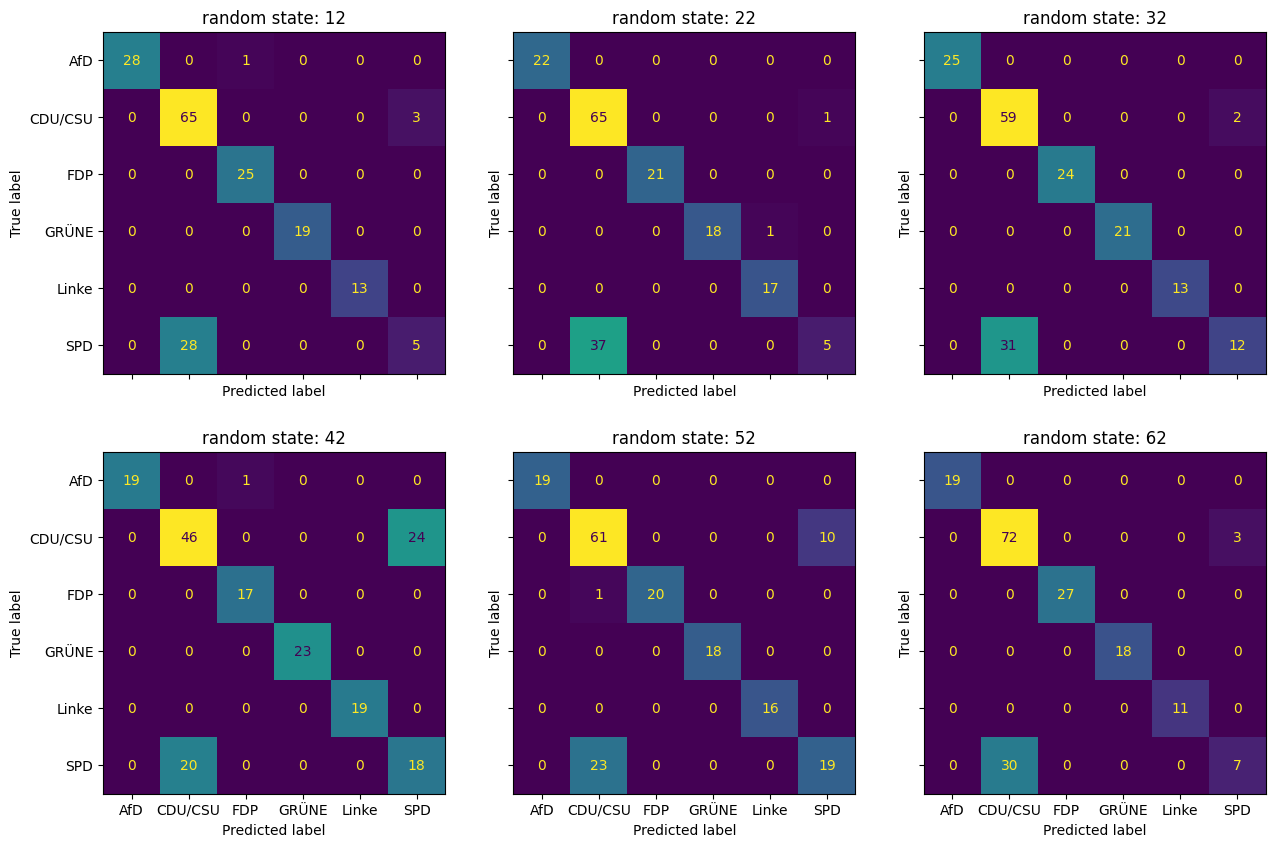

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,10))

# define a list of random states
random_states = [12,22,32,42,52,62]

for ax, random_state in zip(axs.flatten(), random_states):
    
    # Create train and test split
    btvote_data_train, btvote_data_test, btvote_target_train, btvote_target_test = train_test_split(btvote_data, btvote_target, random_state=random_state)

    # fit classifier
    best_model.fit(btvote_data_train, btvote_target_train)

    # predict test data
    prediction = best_model.predict(btvote_data_test)

    # plot confusion matrix
    ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=ax, colorbar=False)

    # add random state as information
    ax.set_title('random state: {}'.format(random_state))

plt.show()

For six random train/test examples, we see that the difficulty always lies with differentiating between CDU/CDU and SPD. Sometimes more SPD MPs are classified as CDU/CSU, sometimes the other way around.